<a href="https://colab.research.google.com/github/mithilgotarne/Convolutional-Neural-Networks/blob/master/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
################################################################################
#
# xNNs_Code_01_Vision_Class_MNIST.py
#
# DESCRIPTION
#
#    TensorFlow MNIST example
#
# INSTRUCTIONS
#
#    1. Go to Google Colaboratory: https://colab.research.google.com/notebooks/welcome.ipynb
#    2. File - New Python 3 notebook
#    3. Cut and paste this file into the cell (feel free to divide into multiple cells)
#    4. Runtime - Change runtime type - Hardware accelerator - GPU
#    5. Runtime - Run all
#
################################################################################


In [0]:
################################################################################
#
# IMPORT
#
################################################################################

# tenorflow
import tensorflow as     tf
from   tensorflow import keras

# additional libraries
import numpy             as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
################################################################################
#
# PARAMETERS
#
################################################################################

# data
DATA_NUM_CLASSES = 10

# model
MODEL_LAYER_0 = 1000
MODEL_LAYER_1 = 100

# training
TRAINING_BATCH_SIZE        = 32
TRAINING_NUM_EPOCHS        = 6
TRAINING_MOMENTUM          = 0.9                    # currently not used
TRAINING_REGULARIZER_SCALE = 0.1                    # currently not used
TRAINING_LR_INITIAL        = 0.001
TRAINING_LR_SCALE          = 0.1
TRAINING_LR_EPOCHS         = 2
TRAINING_LR_STAIRCASE      = True
TRAINING_MAX_CHECKPOINTS   = 5
TRAINING_CHECKPOINT_FILE   = './logs/model_{}.ckpt' # currently not used

In [0]:
################################################################################
#
# PRE PROCESSING
#
################################################################################

def pre_processing_train(image, label):
    
    # note: this function operates on 8 bit data then normalizes to a float
    
    # normalization
    # this constrains values to [0, 1]
    # the mean is not subtracted as there are many 0 values to start in the greyscale image
    image = tf.cast(image, tf.float32)/255.0
    
    return image, label

def pre_processing_test(image, label):
    
    # note: this function operates on 8 bit data then normalizes to a float
    
    # normalization
    # this constrains values to [0, 1]
    # the mean is not subtracted as there are many 0 values to start in the greyscale image
    image = tf.cast(image, tf.float32)/255.0

    return image, label


In [0]:

################################################################################
#
# DATASET
#
################################################################################

# download
mnist = keras.datasets.mnist

# training and testing split
(data_train, labels_train), (data_test, labels_test) = mnist.load_data()

# label typecast
labels_train = labels_train.astype(np.int32)
labels_test  = labels_test.astype(np.int32)
labels_train = np.squeeze(labels_train)
labels_test  = np.squeeze(labels_test)

# dataset
dataset_train = tf.data.Dataset.from_tensor_slices((data_train, labels_train))
dataset_test  = tf.data.Dataset.from_tensor_slices((data_test,  labels_test))

# transformation
dataset_train = dataset_train.repeat().map(pre_processing_train).batch(TRAINING_BATCH_SIZE)
dataset_test  = dataset_test.repeat().map(pre_processing_test).batch(TRAINING_BATCH_SIZE)

# display
# print(data_train.shape)
# print(data_test.shape)
# print(labels_train.shape)
# print(labels_test.shape)


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
################################################################################
#
# ITERATOR
#
################################################################################

# iterator
iterator            = tf.data.Iterator.from_structure(dataset_train.output_types, dataset_train.output_shapes)
iterator_init_train = iterator.make_initializer(dataset_train)
iterator_init_test  = iterator.make_initializer(dataset_test)

# example
# data.shape   = TRAINING_BATCH_SIZE x rows x cols
# labels.shape = TRAINING_BATCH_SIZE x 1
data, labels = iterator.get_next()


Instructions for updating:
Colocations handled automatically by placer.


In [0]:

################################################################################
#
# MODEL - NN
#
################################################################################

# nn model
def model_nn(data, train_state, size_layer_0, size_layer_1, num_classes):
    
    # encoder
    fm       = tf.layers.flatten(data)                                                 # fm.shape = TRAINING_BATCH_SIZE x (rows*cols)
    fm       = tf.layers.dense(fm, size_layer_0, activation=tf.nn.relu, use_bias=True) # fm.shape = TRAINING_BATCH_SIZE x size_layer_0
    features = tf.layers.dense(fm, size_layer_1, activation=tf.nn.relu, use_bias=True) # fm.shape = TRAINING_BATCH_SIZE x size_layer_1
    
    # decoder
    # predictions.shape = TRAINING_BATCH_SIZE x num_classes
    predictions = tf.layers.dense(features, num_classes, activation=None, use_bias=True)
    
    # return
    return predictions


In [0]:
################################################################################
#
# TRAINING
#
################################################################################

# state
train_state = tf.placeholder(tf.bool, name='train_state')

# data
num_train         = len(data_train)
num_test          = len(data_test)
num_batches_train = int(num_train/TRAINING_BATCH_SIZE)
num_batches_test  = int(num_test/TRAINING_BATCH_SIZE)

# display
# print(num_train)
# print(num_test)
# print(num_batches_train)
# print(num_batches_test)

# model
predictions      = model_nn(data, train_state, MODEL_LAYER_0, MODEL_LAYER_1, DATA_NUM_CLASSES)
predictions_test = np.zeros((num_test, DATA_NUM_CLASSES), dtype=np.float32)

# accuracy
accuracy = tf.reduce_sum(tf.cast(tf.equal(tf.argmax(predictions, 1), tf.cast(labels, tf.int64)), tf.float32))

# loss
loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=predictions)

# optimizer
global_step   = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(TRAINING_LR_INITIAL, global_step, TRAINING_LR_EPOCHS*num_batches_train, TRAINING_LR_SCALE, staircase=TRAINING_LR_STAIRCASE)
update_ops    = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
    # optimizer = tf.train.MomentumOptimizer(learning_rate, TRAINING_MOMENTUM, use_nesterov=True).minimize(loss, global_step=global_step)

# saver
# saver = tf.train.Saver(max_to_keep=TRAINING_MAX_CHECKPOINTS)

# create a session
session = tf.Session()
    
# initialize global variables
session.run(tf.global_variables_initializer())

# cycle through the epochs
for epoch_index in range(TRAINING_NUM_EPOCHS):
    
    # train
    # initialize the iterator to the training dataset
    # cycle through the training batches
    # example, encoder, decoder, error, gradient computation and update
    session.run(iterator_init_train)
    for batch_index in range(num_batches_train):
        session.run(optimizer, feed_dict={train_state: True})

    # validate
    # initialize the iterator to the testing dataset
    # reset the accuracy statistics
    # cycle through the testing batches
    # example, encoder, decoder, accuracy
    session.run(iterator_init_test)
    num_correct = 0
    for batch_index in range(num_batches_test):
        num_correct_batch, predictions_batch    = session.run([accuracy, predictions], feed_dict={train_state: False})
        num_correct                            += num_correct_batch
        row_start                               = batch_index*TRAINING_BATCH_SIZE
        row_end                                 = (batch_index + 1)*TRAINING_BATCH_SIZE
        predictions_test[row_start:row_end, :]  = predictions_batch

    # display
    print('Epoch {0:3d}: top 1 accuracy on the test set is {1:5.2f} %'.format(epoch_index, (100.0*num_correct)/(TRAINING_BATCH_SIZE*num_batches_test)))

    # save
    # saver.save(session, TRAINING_CHECKPOINT_FILE.format(epoch_index))

# close the session
session.close()

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Epoch   0: top 1 accuracy on the test set is 95.65 %
Epoch   1: top 1 accuracy on the test set is 96.36 %
Epoch   2: top 1 accuracy on the test set is 98.25 %
Epoch   3: top 1 accuracy on the test set is 98.31 %
Epoch   4: top 1 accuracy on the test set is 98.42 %
Epoch   5: top 1 accuracy on the test set is 98.45 %


Predicted label: 7 and actual label: 7


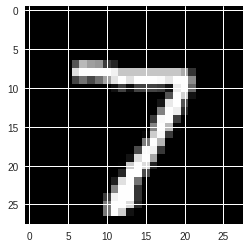

Predicted label: 2 and actual label: 2


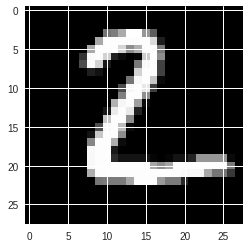

Predicted label: 1 and actual label: 1


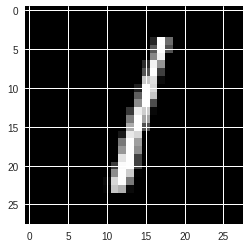

Predicted label: 0 and actual label: 0


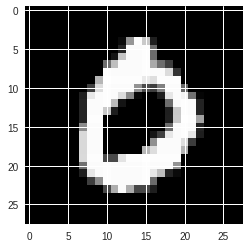

Predicted label: 4 and actual label: 4


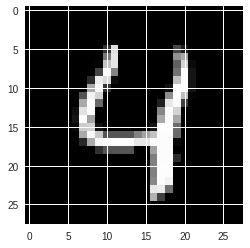

Predicted label: 1 and actual label: 1


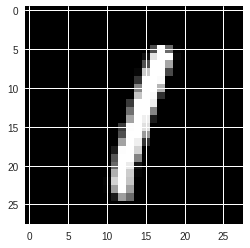

Predicted label: 4 and actual label: 4


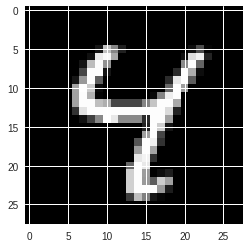

Predicted label: 9 and actual label: 9


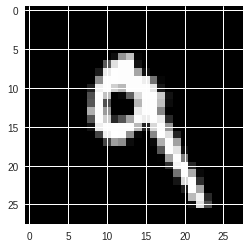

Predicted label: 5 and actual label: 5


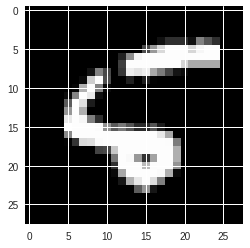

Predicted label: 9 and actual label: 9


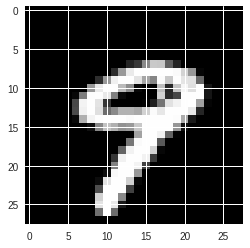

Predicted label: 0 and actual label: 0


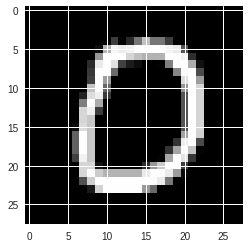

Predicted label: 6 and actual label: 6


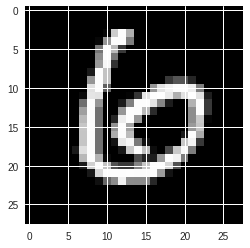

Predicted label: 9 and actual label: 9


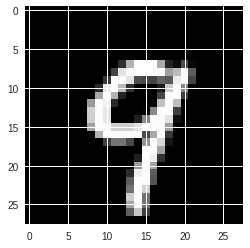

Predicted label: 0 and actual label: 0


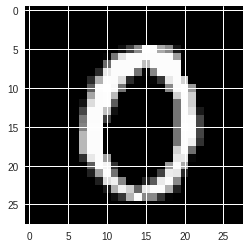

Predicted label: 1 and actual label: 1


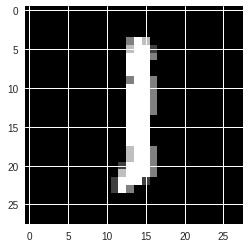

Predicted label: 5 and actual label: 5


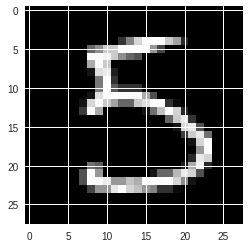

Predicted label: 9 and actual label: 9


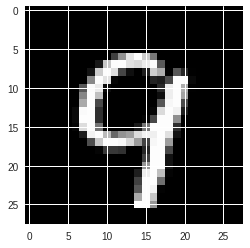

Predicted label: 7 and actual label: 7


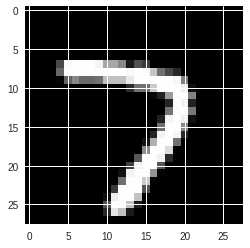

Predicted label: 3 and actual label: 3


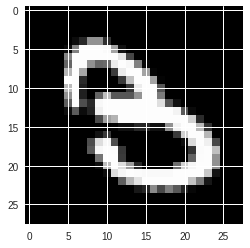

Predicted label: 4 and actual label: 4


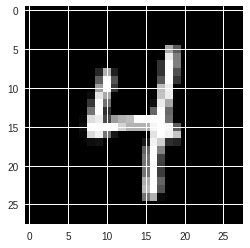

Predicted label: 9 and actual label: 9


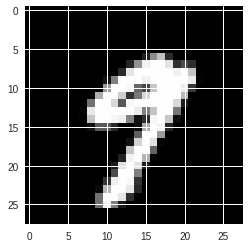

Predicted label: 6 and actual label: 6


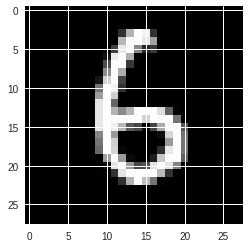

Predicted label: 6 and actual label: 6


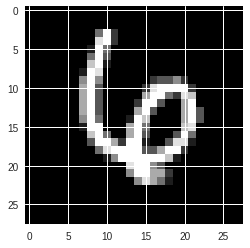

Predicted label: 5 and actual label: 5


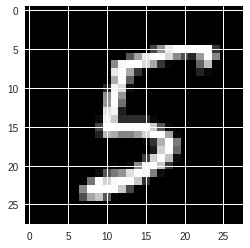

Predicted label: 4 and actual label: 4


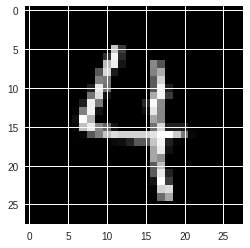

Predicted label: 0 and actual label: 0


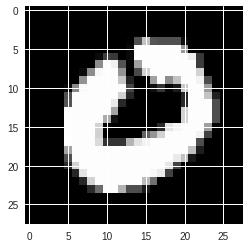

Predicted label: 7 and actual label: 7


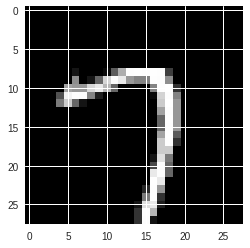

Predicted label: 4 and actual label: 4


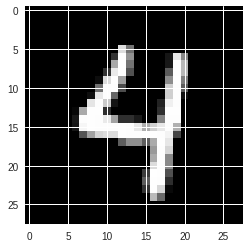

Predicted label: 0 and actual label: 0


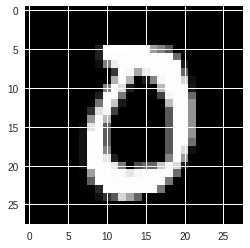

Predicted label: 1 and actual label: 1


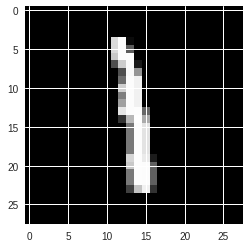

Predicted label: 3 and actual label: 3


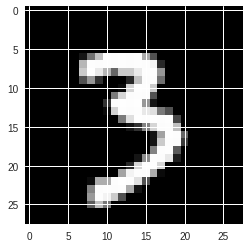

Predicted label: 1 and actual label: 1


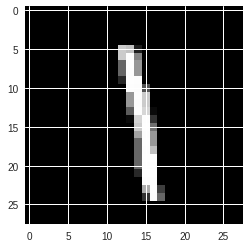

In [0]:
################################################################################
#
# DISPLAY
#
################################################################################

# create a session
session = tf.Session()

# initialize global variables
session.run(tf.global_variables_initializer())

# initialize the test iterator
session.run(iterator_init_test)

# cycle through a few batches
for batch_index in range(1):
    
    # generate data and labels
    data_batch, labels_batch = session.run([data, labels])
    
    # convert the final saved predictions to labels
    row_start          = batch_index*TRAINING_BATCH_SIZE
    row_end            = (batch_index + 1)*TRAINING_BATCH_SIZE
    predictions_labels = np.argmax(predictions_test[row_start:row_end, :], axis=1)
    
    # cycle through the images in the batch
    for image_index in range(TRAINING_BATCH_SIZE):
        
        # display the predicted label, actual label and image
        print('Predicted label: {0:1d} and actual label: {1:1d}'.format(predictions_labels[image_index], labels_batch[image_index]))
        plt.imshow(data_batch[image_index, :, :], cmap='gray')
        plt.show()

# close the session
session.close()